#### ML Modeling

In [1]:
from pathlib import Path
import pandas as pd
from sklearn.model_selection import train_test_split

In [2]:
# Load Data
DATA_PATH = Path("../data/processed/modeling.csv")
df= pd.read_csv(DATA_PATH)
ml_df = df.copy()

In [3]:
 ml_df.head()

,Customer ID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RF_Score,Segment,clv
0,12346,321,12,400.94,2,5,2,25,Cannot Lose,190.421347
1,12608,400,1,258.23,2,1,2,21,Hibernating,0.000000
2,12745,482,2,614.85,1,2,3,12,Hibernating,188.963244
3,12746,536,1,253.65,1,1,2,11,Hibernating,0.000000
4,12747,17,25,7503.23,5,5,5,55,Champions,3010.101479


In [4]:
# Feature engineering and Train-Test Split
# Target variable 'Churn'
# 1 = Churned/At-Risk (Hibernating, About to Sleep)
# 0 = Active (all other segments)
churn_segments = ['Hibernating', 'About to Sleep']
ml_df['Churn'] = ml_df['Segment'].apply(lambda x: 1 if x in churn_segments else 0)

# Features (X) and targets (y)
X = ml_df[['Recency', 'Frequency', 'Monetary']]
y = ml_df['Churn']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

print("Data Prepared for ML Modeling")
print(f"Shape of training features (X_train): {X_train.shape}")
print(f"Shape of testing features (X_test): {X_test.shape}")
print(f"\nDistribution of Churn in the training set:\n{y_train.value_counts(normalize=True)}")
print(f"\nDistribution of Churn in the testing set:\n{y_test.value_counts(normalize=True)}")

Data Prepared for ML Modeling
Shape of training features (X_train): (4102, 3)
Shape of testing features (X_test): (1758, 3)

Distribution of Churn in the training set:
Churn
0    0.680156
1    0.319844
Name: proportion, dtype: float64

Distribution of Churn in the testing set:
Churn
0    0.680319
1    0.319681
Name: proportion, dtype: float64


In [5]:
# Preprocessing Pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

# Define numeric columns
numeric_features = ['Recency', 'Frequency', 'Monetary']

#Pieline for the numeric data
numeric_transformer = Pipeline(steps=[(
    ('scaler', StandardScaler())
)])

# Use ColumnTransformer to apply the transformations to the correct columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)
    ],
    remainder='passthrough'
)

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Define models to test
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'SVM': SVC(probability=True, random_state=42) #probability=True is needed for ROC AUC
} 

results = []

print("Training and Evaluating Baseline Models (using Cross-Validations)")
for name, model in models.items():
    # Chain the preprocessor and the model together in a single pipeline
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', model)])

    # 5-fold cross-validation to evaluate
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='roc_auc')

    results.append({'model': name, 'mean_roc_auc': cv_scores.mean(), 'std_roc_auc': cv_scores.std()})

# Display the results
results_df = pd.DataFrame(results).sort_values(by='mean_roc_auc', ascending=False)
print("Baseline Model Performance")
display(results_df)

Training and Evaluating Baseline Models (using Cross-Validations)
Baseline Model Performance


,model,mean_roc_auc,std_roc_auc
2,Gradient Boosting,0.993777,0.001315
1,Random Forest,0.993182,0.001645
3,SVM,0.985777,0.002510
0,Logistic Regression,0.974532,0.004134


### Inference
The results show that tree-based ensemble models perform exceptionally well on this dataset. Both Gradient Boosting and Random Forest achieved nearly perfect ROC AUC scores(over 0.99), indicating they are highly effective at distinguishing between churning and active customers

In [7]:
# Hyperparameter tuning
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline

# Define pipeline with preprocessor and chosen model
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                          ('classifier', GradientBoostingClassifier(random_state=42))])

# Define the grid of parameters to search
# Test different numbers of trees, learning rates, and tree depths.
# Note the 'classifier__' prefix, which tells the pipeline to apply these to the classifier step.
param_grid = {
    'classifier__n_estimators': [100,200],
    'classifier__learning_rate': [0.05,0.1],
    'classifier__max_depth': [3,5]
}

# Set up the GridSearchCV object
# n = -1 uses all available CPU cores to speed up the process.
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='roc_auc',n_jobs=-1, verbose=1)

# Run the grid search on the training data
print("Start Hyperparameter Tuning for Gradient Boosting...")
grid_search.fit(X_train, y_train)

#Print the results
print("Tuning Complete")
print(f"Best Parameters Found: {grid_search.best_params_}")
print(f"Best ROC AUC Score from Cross-Validation: {grid_search.best_score_:.4f}")

# Store the best model found by the grid search
best_model = grid_search.best_estimator_

Start Hyperparameter Tuning for Gradient Boosting...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Tuning Complete
Best Parameters Found: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__n_estimators': 200}
Best ROC AUC Score from Cross-Validation: 0.9939


Final Model Performance on Unseen Test Data
               precision    recall  f1-score   support

Not Churn (0)       0.98      0.96      0.97      1196
    Churn (1)       0.92      0.96      0.94       562

     accuracy                           0.96      1758
    macro avg       0.95      0.96      0.95      1758
 weighted avg       0.96      0.96      0.96      1758

ROC AUC Score: 0.9936


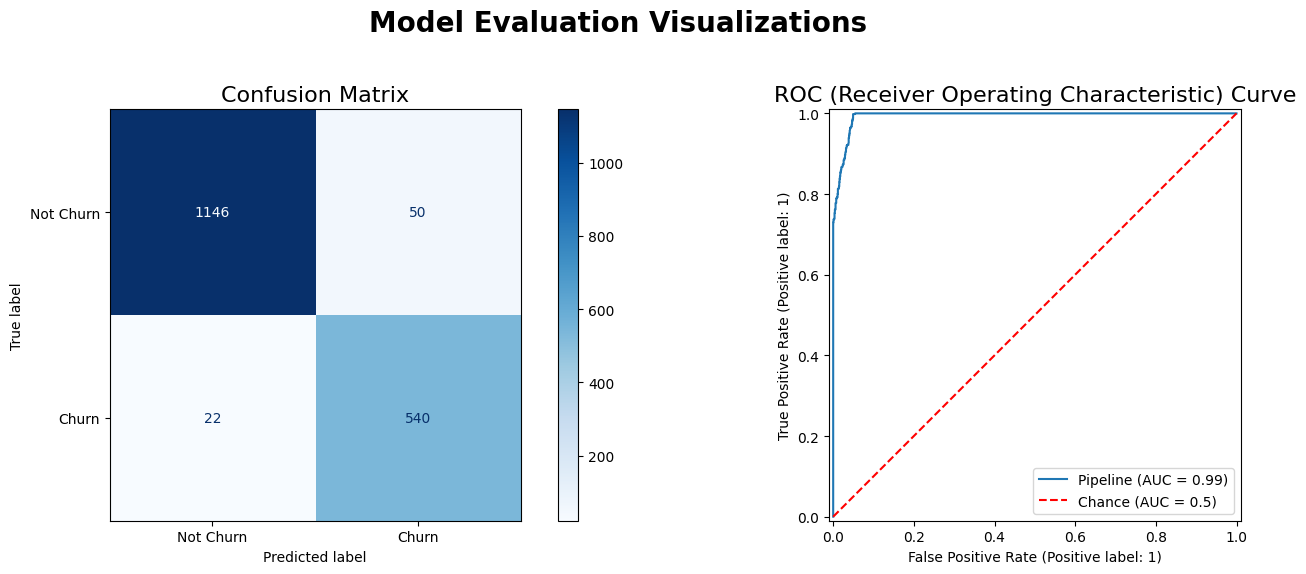

In [8]:
# ML modeling: Final Evaluation on Test Set
from sklearn.metrics import classification_report, roc_auc_score, ConfusionMatrixDisplay, RocCurveDisplay
import matplotlib.pyplot as plt

# Make Predictions on the Test Set
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:,1] # Probabilities for the positive class

#Generate Evaluation Metrics
print("Final Model Performance on Unseen Test Data")
print(classification_report(y_test, y_pred, target_names=['Not Churn (0)', 'Churn (1)']))

# Print the ROC AUC Score
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC AUC Score: {roc_auc:.4f}")

# Create Visualizations
fig, axes = plt.subplots(1,2, figsize=(16,6))
fig.suptitle("Model Evaluation Visualizations", fontsize=20, fontweight='bold')

# Plot the Confusion Matrix
ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test, 
                                      display_labels=['Not Churn', 'Churn'],
                                      cmap='Blues', ax=axes[0])
axes[0].set_title('Confusion Matrix', fontsize=16)

# Plot the ROC Curve
RocCurveDisplay.from_estimator(best_model, X_test, y_test, ax=axes[1])
axes[1].set_title('ROC (Receiver Operating Characteristic) Curve', fontsize=16)
axes[1].plot([0, 1], [0, 1], 'r--', label='Chance (AUC = 0.5)') # Add chance line
axes[1].legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

#### Inference
The churn prediction model is highly accurate and commercially valuable. With an ROC AUC score of 0.9936, it demonstrates a near perfect ability to distinguish between customers who are at risk of churning and those who are not.<br>

From a business perspective, the two most important metrics are:
* Recall (96%): The model successfully identifies 96% of all customers who are truly at risk. This means our retention campaigns will reach almost everyone they need to.
* Precision (92%): When the model predicts a customer will churn, it's correct 92% of the time. This ensures that our marketing budget is spent efficently, targeting the right customers with retention offers.

Conclusion: This model provides the business with a reliable, automated tool to move from a reactive  to proactive retention strategy, allowing them to save high-value customers before they leave.